# Shooting Improvements

### Introduction
In this notebook, we are going to attempt to understand how likely it is for a player to improve in both their 3pt shooting and their free throw shooting over the course of their career. 

Questions I hope to answer:
- What's the trend for player shooting across their career?
- What does shooting percentage look like if we consider age instead of just years of experience?
- Can players who are bad at shooting early on improve?
- If you start your career with a high shooting percentage, will it just keep going up?

Note: In a separate notebook, I've performed some transformations to get a dataset containing shooting (and other stats) for each player

Credit to the nba_api library: https://github.com/swar/nba_api

In [61]:
from nba_api.stats.endpoints import commonplayerinfo, playerdashboardbyyearoveryear, commonteamroster
from nba_api.stats.static import players, teams
import time
import pandas as pd
import numpy as np
import math

import warnings
warnings.filterwarnings("ignore")

### Part 1: Baselines

First we should establish some baselines. I want to understand what an average player does in a season in terms of shooting

In [32]:
player_data = pd.read_csv("total_player_stats_by_year.csv")
player_data.head(10)

,Unnamed: 0,GROUP_VALUE,GP,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,...,BLK,PTS,PLUS_MINUS,experience,PLAYER_NAME,PLAYER_ID,age,yr,adj_age,max_experience
0,0,2015-16,55,646.876667,71,175,0.406000,22,83,0.265,...,25,208,7,0,Justin Anderson,1626147,24,2015,21,2
1,1,2016-17,150,2454.466667,372,878,0.429333,116,388,0.298,...,46,1064,-388,1,Justin Anderson,1626147,24,2016,22,2
2,2,2017-18,38,519.150000,87,202,0.431000,34,103,0.330,...,7,236,-82,2,Justin Anderson,1626147,24,2017,23,2
3,3,2017-18,56,974.210000,144,382,0.377000,72,199,0.362,...,5,405,-149,0,Tyler Dorsey,1628416,22,2017,21,1
4,4,2018-19,7,68.898333,10,27,0.370000,2,9,0.222,...,0,26,-3,1,Tyler Dorsey,1628416,22,2018,22,1
5,5,2018-19,13,227.350000,22,59,0.373000,11,31,0.355,...,3,62,7,0,Kevin Huerter,1628989,20,2018,20,0
6,6,2017-18,6,27.728333,5,11,0.455000,2,5,0.400,...,0,12,-12,0,Daniel Hamilton,1627772,23,2017,22,0
7,7,2018-19,13,260.753333,33,81,0.407000,13,37,0.351,...,7,89,-53,0,Omari Spellman,1629016,21,2018,21,0
8,8,2010-11,29,284.513333,28,72,0.389000,1,5,0.200,...,9,76,8,0,Jeremy Lin,202391,30,2010,22,8
9,9,2011-12,35,940.431667,171,383,0.446000,24,75,0.320,...,9,512,142,1,Jeremy Lin,202391,30,2011,23,8


In [31]:
exp_players = player_data[player_data["max_experience"] > 4]
exp_players['FG3A'].describe()
# The average experienced player attempts 162 3s per season

count    1870.000000
mean      162.797861
std       166.842688
min         0.000000
25%        16.000000
50%       118.000000
75%       263.750000
max       902.000000
Name: FG3A, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10ddf72b0>]],
      dtype=object)

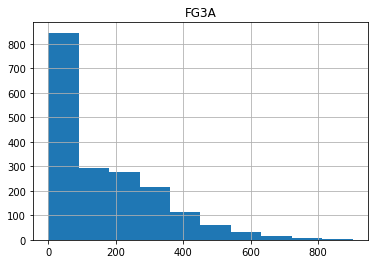

In [29]:
exp_players.hist(column='FG3A') # Here we see how the attempts are distributed across players

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10ed27e10>]],
      dtype=object)

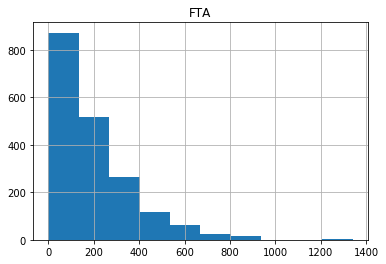

In [34]:
exp_players = player_data[player_data["max_experience"] > 4]
exp_players.hist(column='FTA') # Similar phenomena with free throw attempts

In [22]:
experienced_players = player_data[player_data["max_experience"] > 4]
qualified_players = experienced_players[experienced_players["FG3A"] > 120] # Players who shoot ~1.5 3s per game
qualified_players['FG3M'].sum() / qualified_players['FG3A'].sum()

0.36617071203611457

Across all experienced players, the career average is 0.36.
This likely doesn't tell a perfect picture though; better shooters will probably shoot more and therefore
buoy the average shooting percentage. We need to look at this on a player by player basis

In [35]:
career_shooting = qualified_players.groupby(['PLAYER_ID']).agg({'FG3M': np.sum, 'FG3A': np.sum, 
                                                                'FTM': np.sum, 'FTA': np.sum})
career_shooting['3PCT'] = career_shooting['FG3M'] / career_shooting['FG3A']
career_shooting['FTPCT'] = career_shooting['FTM'] / career_shooting['FTA']

career_shooting['3PCT'].describe()

count    152.000000
mean       0.359009
std        0.028861
min        0.247082
25%        0.340190
50%        0.359166
75%        0.377488
max        0.444840
Name: 3PCT, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10ebc8b38>]],
      dtype=object)

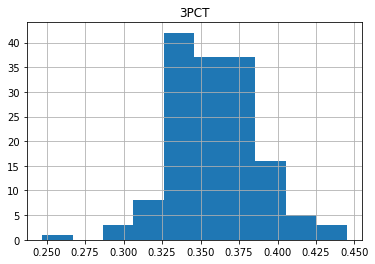

In [30]:
career_shooting.hist(column='3PCT')

In [37]:
career_shooting['FTPCT'].describe()

count    152.000000
mean       0.794116
std        0.062125
min        0.507463
25%        0.757827
50%        0.803738
75%        0.835689
max        0.919355
Name: FTPCT, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10e78ac88>]],
      dtype=object)

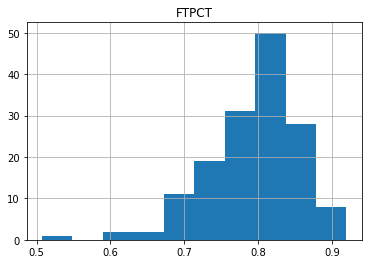

In [36]:
career_shooting.hist(column='FTPCT')

#### Baselines Conclusions

I think this gives us a pretty good idea of what to base our assumptions off of once we start looking further into the data. Qualified players (who shoot > 120 attempts per season) average about 36% from 3, which is a slight tick above conventional wisdom of league average shooting. Free throwing shooting is ~79% on average, which seems reasonable as well.

The shape of the shot attempt distributions surprised me a bit, but on further thought in makes sense, especially since we aren't using per 36 numbers or anything like that. 

### Part 2: Effects of experience on shooting

Let's see what shooting splits look at based on how many years a player has been in the league

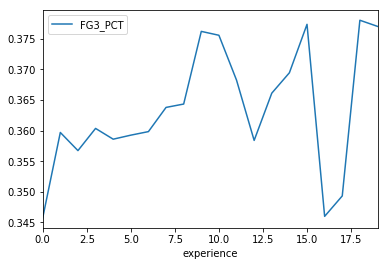

In [42]:
shots_by_experience = qualified_players.groupby('experience').agg({'FG3_PCT': np.mean}).reset_index()
shots_by_experience.plot.line(x='experience', y='FG3_PCT')

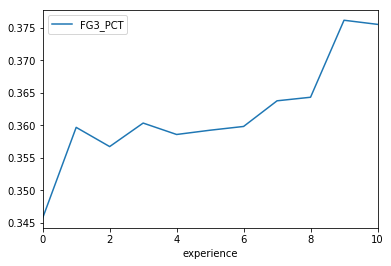

In [44]:
# There's a lot of noise at the end here, what if we restrict the sample a bit?
shots_by_experience[shots_by_experience["experience"] < 11].plot.line(x='experience', y='FG3_PCT')

It looks like first year plays are poor at shooting, but after the first year the percentages bounce up to career averages. Players can expect a slight uptick in shooting as their career progresses but nothing extreme.

What about free throws?

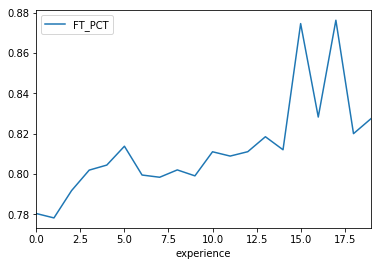

In [47]:
fts_by_experience = qualified_players.groupby('experience').agg({'FT_PCT': np.mean}).reset_index()
fts_by_experience.plot.line(x='experience', y='FT_PCT')

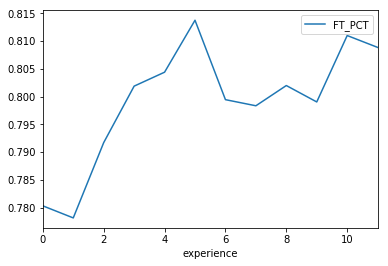

In [48]:
fts_by_experience[fts_by_experience["experience"] < 12].plot.line(x='experience', y='FT_PCT')

Here we see that it takes a little longer for free throw shooting to stabilize, although the gains are slim

### Part 3: Effects of age on shooting

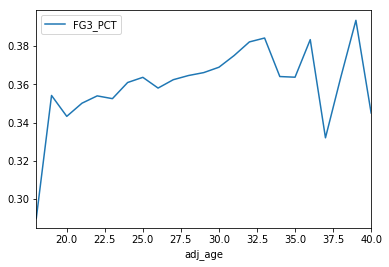

In [51]:
shots_by_age = qualified_players.groupby('adj_age').agg({'FG3_PCT': np.mean}).reset_index()
shots_by_age.plot.line(x='adj_age', y='FG3_PCT')

Once again, we find that young players are truly awful at shooting. However, after some rough numbers early on we can see that their shooting steadily progress deep into their career

In [73]:
binned_players = qualified_players.groupby('PLAYER_ID')[['FG3M', 'FG3A']].cumsum()
binned_players['3PCT'] = binned_players['FG3M'] / binned_players['FG3A']
binned_players['bin'] = np.floor(binned_players['FG3A'] / 100)
binned_players.head(10)

,FG3A,FG3M,3PCT,bin
10,257,87,0.338521,2
11,486,169,0.347737,4
12,662,234,0.353474,6
13,888,310,0.349099,8
14,1044,368,0.352490,10
26,141,50,0.354610,1
29,236,95,0.402542,2
30,633,257,0.406003,6
31,946,378,0.399577,9
32,1077,423,0.392758,10


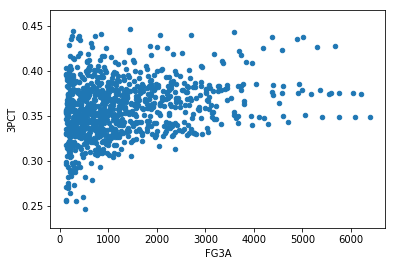

In [74]:
binned_players.plot.scatter(x='FG3A', y='3PCT')

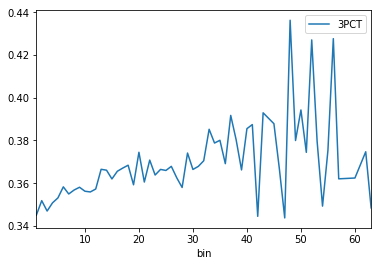

In [71]:
binned_player_shooting = binned_players.groupby('bin')[["3PCT"]].mean().reset_index()
# binned_player_shooting.plot.line(x='bin', y='3PCT')
# I excluded later bins because there was lots of variance at the end
binned_player_shooting[binned_player_shooting["bin"] < 40].plot.line(x='bin', y='3PCT') 

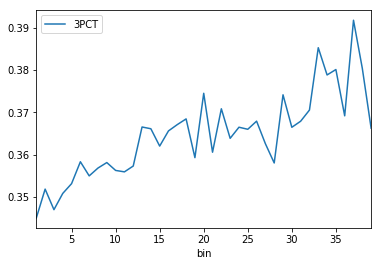

In [72]:
binned_player_shooting[binned_player_shooting["bin"] < 40].plot.line(x='bin', y='3PCT') # I excluded later bins because there was lots of variance at the end

In [75]:
qualified_players.head(10)

,Unnamed: 0,GROUP_VALUE,GP,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,...,BLK,PTS,PLUS_MINUS,experience,PLAYER_NAME,PLAYER_ID,age,yr,adj_age,max_experience
10,10,2012-13,82,2639.955000,396,897,0.441,87,257,0.339,...,29,1095,133,2,Jeremy Lin,202391,30,2012,24,8
11,11,2013-14,71,2054.025000,295,662,0.446,82,229,0.358,...,27,890,175,3,Jeremy Lin,202391,30,2013,25,8
12,12,2014-15,74,1906.723333,277,654,0.424,65,176,0.369,...,32,832,-253,4,Jeremy Lin,202391,30,2014,26,8
13,13,2015-16,78,2047.555000,300,728,0.412,76,226,0.336,...,42,914,84,5,Jeremy Lin,202391,30,2015,27,8
14,14,2016-17,36,882.588333,175,400,0.438,58,156,0.372,...,14,523,-83,6,Jeremy Lin,202391,30,2016,28,8
26,26,2017-18,62,1542.273333,250,477,0.524,50,141,0.355,...,51,617,-158,4,Dewayne Dedmon,203473,29,2017,28,5
29,29,1999-00,82,3127.983333,788,1696,0.465,95,236,0.403,...,92,2107,181,1,Vince Carter,1713,41,1999,22,20
30,30,2000-01,75,2980.056667,762,1656,0.460,162,397,0.408,...,82,2070,323,2,Vince Carter,1713,41,2000,23,20
31,31,2001-02,60,2385.645000,559,1307,0.428,121,313,0.387,...,45,1484,68,3,Vince Carter,1713,41,2001,24,20
32,32,2002-03,43,1470.348333,355,760,0.467,45,131,0.344,...,41,884,-27,4,Vince Carter,1713,41,2002,25,20


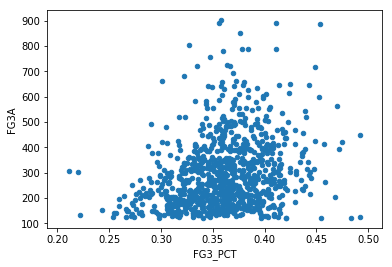

In [76]:
qualified_players.plot.scatter(x='FG3_PCT', y='FG3A')

Good shooters don't necessarily take much more attempts than bad ones, although terrible shooters don't shoot much at all